In [1]:
%cd ..

D:\ryanh\github\cell_assembly_replay


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from cell_assembly_replay import functions,replay_run,replay_fig
from nelpy.analysis import replay
import multiprocessing
from joblib import Parallel, delayed
from scipy.ndimage import convolve


D:\ryanh\Anaconda3\envs\replay\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


## generate simulated posterior probability matrices

In [3]:
def make_gaussian(mu=20,sigma=3,bins=40):
    bins = np.arange(bins)
    return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2))

In [4]:
Pr = np.zeros((40,10))

dt = .02
dp = 3
n_time = Pr.shape[1]
max_position = 120

time = np.arange(n_time) * dt
place_bin_edges = np.arange(0, max_position + dp, dp)
place_bin_centers = place_bin_edges[:-1] + np.diff(place_bin_edges) / 2

time_bin_edges = np.arange(n_time+1) * dt

t, p = np.meshgrid(time_bin_edges, place_bin_edges)

D:\ryanh\github\cell_assembly_replay\cell_assembly_replay\replay_run.py:159: RuntimeWarning: divide by zero encountered in true_divide
D:\ryanh\github\cell_assembly_replay\cell_assembly_replay\replay_run.py:159: RuntimeWarning: invalid value encountered in true_divide
D:\ryanh\github\cell_assembly_replay\cell_assembly_replay\replay_run.py:159: RuntimeWarning: invalid value encountered in subtract
D:\ryanh\github\cell_assembly_replay\cell_assembly_replay\replay_run.py:200: RuntimeWarning: invalid value encountered in add


Text(0.5, 1.0, '0.4530872346733899')

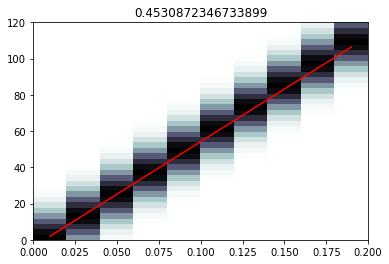

In [5]:
Pr = np.zeros((40,10))
for i in range(10):
    Pr[:,i] = make_gaussian(mu=i*4)
    
start_position, velocity, radon_position, score = replay_run.detect_line_with_radon(
    Pr.T,
    dt,  # s
    dp,  # cm
    projection_angles=np.arange(-90, 90, 0.5),  # degrees
    filter_invalid_positions=True,
    incorporate_nearby_positions=False,
    nearby_positions_max=15,  # cm
)

plt.pcolormesh(t, p, Pr,cmap=plt.cm.bone_r)
plt.plot(time+dt/2,radon_position,color='red')
plt.title(score)

D:\ryanh\github\cell_assembly_replay\cell_assembly_replay\replay_run.py:159: RuntimeWarning: divide by zero encountered in true_divide
D:\ryanh\github\cell_assembly_replay\cell_assembly_replay\replay_run.py:159: RuntimeWarning: invalid value encountered in true_divide
D:\ryanh\github\cell_assembly_replay\cell_assembly_replay\replay_run.py:159: RuntimeWarning: invalid value encountered in subtract
D:\ryanh\github\cell_assembly_replay\cell_assembly_replay\replay_run.py:200: RuntimeWarning: invalid value encountered in add


Text(0.5, 1.0, '0.18607879662365165')

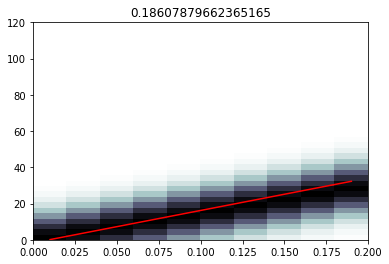

In [6]:
Pr = np.zeros((40,10))
for i in range(10):
    Pr[:,i] = make_gaussian(mu=i)
    
start_position, velocity, radon_position, score = replay_run.detect_line_with_radon(
    Pr.T,
    dt,  # s
    dp,  # cm
    projection_angles=np.arange(-90, 90, 0.5),  # degrees
    filter_invalid_positions=True,
    incorporate_nearby_positions=False,
    nearby_positions_max=15,  # cm
)

plt.pcolormesh(t, p, Pr,cmap=plt.cm.bone_r)
plt.plot(time+dt/2,radon_position,color='red')
plt.title(score)

D:\ryanh\github\cell_assembly_replay\cell_assembly_replay\replay_run.py:159: RuntimeWarning: divide by zero encountered in true_divide
D:\ryanh\github\cell_assembly_replay\cell_assembly_replay\replay_run.py:159: RuntimeWarning: invalid value encountered in true_divide
D:\ryanh\github\cell_assembly_replay\cell_assembly_replay\replay_run.py:159: RuntimeWarning: invalid value encountered in subtract
D:\ryanh\github\cell_assembly_replay\cell_assembly_replay\replay_run.py:200: RuntimeWarning: invalid value encountered in add


Text(0.5, 1.0, '0.13298076013381088')

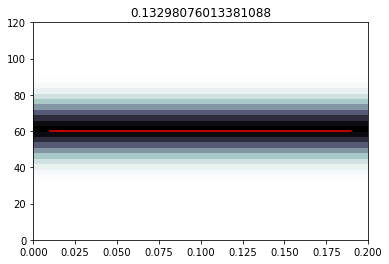

In [7]:
Pr = np.zeros((40,10))
for i in range(10):
    Pr[:,i] = make_gaussian(mu=20)
    
start_position, velocity, radon_position, score = replay_run.detect_line_with_radon(
    Pr.T,
    dt,  # s
    dp,  # cm
    projection_angles=np.arange(-90, 90, 0.5),  # degrees
    filter_invalid_positions=True,
    incorporate_nearby_positions=False,
    nearby_positions_max=15,  # cm
)

plt.pcolormesh(t, p, Pr,cmap=plt.cm.bone_r)
plt.plot(time+dt/2,radon_position,color='red')
plt.title(score)

In [21]:
from scipy.special import cotdg
from skimage.transform import radon
from scipy.stats import multivariate_normal, rv_histogram

def convert_polar_to_slope_intercept(
    n_pixels_from_center, projection_angle, center_pixel
):
    """ From Eric Denovellis """
    velocity = -cotdg(-projection_angle)
    start_position = (
        n_pixels_from_center / (np.sin(-np.deg2rad(projection_angle)) + np.finfo(float).eps)
        - velocity * center_pixel[0]
        + center_pixel[1]
    )
    return start_position, velocity

def detect_line_with_radon(
    posterior,
    dt,  # s
    dp,  # cm
    projection_angles=np.arange(-90, 90, 0.5),  # degrees
    filter_invalid_positions=True,
    incorporate_nearby_positions=True,
    nearby_positions_max=15,  # cm
):

    if incorporate_nearby_positions:
        n_nearby_bins = int(nearby_positions_max / 2 // dp)
        filt = np.ones(2 * n_nearby_bins + 1)
        posterior = np.apply_along_axis(
            lambda time_bin: np.convolve(time_bin, filt, mode="same"),
            axis=1, arr=posterior
        )
    else:
        n_nearby_bins = 1
    # Sinogram is shape (pixels_from_center, projection_angles)
    sinogram = radon(
        posterior.T, theta=projection_angles, circle=False,
        preserve_range=False
    )
    n_time, n_position_bins = posterior.shape
    center_pixel = np.asarray((n_time // 2, n_position_bins // 2))
    pixels_from_center = np.arange(
        -sinogram.shape[0] // 2 + 1, sinogram.shape[0] // 2 + 1)

    if filter_invalid_positions:
        start_positions, velocities = convert_polar_to_slope_intercept(
            pixels_from_center[:, np.newaxis],
            projection_angles[np.newaxis, :],
            center_pixel,
        )
        end_positions = start_positions + velocities * (n_time - 1)
        sinogram[(start_positions < 0) |
                 (start_positions > n_position_bins - 1)] = 0.0
        sinogram[(end_positions < 0) |
                 (end_positions > n_position_bins - 1)] = 0.0
        sinogram[:, np.isinf(velocities.squeeze())] = 0.0

    # Find the maximum of the sinogram
    n_pixels_from_center_ind, projection_angle_ind = np.unravel_index(
        indices=np.argmax(sinogram), shape=sinogram.shape
    )
    projection_angle = projection_angles[projection_angle_ind]
    n_pixels_from_center = pixels_from_center[n_pixels_from_center_ind]

    # Normalized score based on the integrated projection
    score = np.max(sinogram) / (n_time * n_nearby_bins)
#     score = np.max(sinogram) 
    
    # Convert from polar form to slope-intercept form
    start_position, velocity = convert_polar_to_slope_intercept(
        n_pixels_from_center, projection_angle, center_pixel
    )

    # Convert from pixels to position units
    start_position *= dp
    velocity *= dp / dt

    # Estimate position for the posterior
    time = np.arange(n_time) * dt
    radon_position = start_position + velocity * time

    return start_position, velocity, radon_position, score, sinogram, projection_angle

def sub2ind(n_cols, rows, cols):
    return rows*n_cols + cols

def _score_line(posterior, fit_line, nearby_positions_max = 3, incorporate_nearby_positions=True):
    
    nanbins = np.isnan(np.max(posterior_array, axis=0))
    n_nanbins = np.count_nonzero(nanbins)
    posterior_array[:, nanbins] = 0
    posterior_median = np.median(posterior_array, axis=0)

    fit_line = np.around(fit_line).astype(int) # Find nearest position bin
    
    # precondition matrix kernel for banded summation
    if incorporate_nearby_positions is False:
        nearby_positions_max = 0
    k = np.zeros((2*nearby_positions_max+1, 3))
    k[:,1] = 1
    precond_posterior = convolve(posterior_array, k, mode='constant', cval=0.0)

    NP, NT = posterior_array.shape

    ci = np.arange(NT)
    scores_outside_track = posterior_median[((fit_line > NP - 1) & ~nanbins) | ((fit_line < 0) & ~nanbins)]

    coords = sub2ind(NT, fit_line, ci)
    coords = coords[(fit_line < NP) & (fit_line >= 0) & (~nanbins)]
    scores_within_track = np.take(precond_posterior, coords)

    score_within_track = np.sum(scores_within_track)
    score_outside_track = np.sum(scores_outside_track)

    score = (score_within_track + score_outside_track)/NT

    return score


<ipython-input-21-7d05f16ece35>:52: RuntimeWarning: invalid value encountered in add


0.5847443207161391

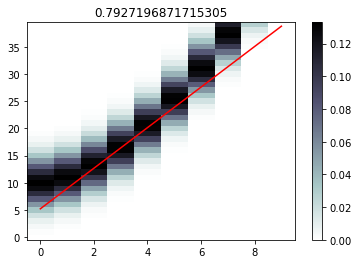

In [25]:
Pr = np.zeros((40,10))
for i in range(10):
    Pr[:,i] = make_gaussian(mu=10+i**1.7)
    
start_position, velocity, radon_position, score,sinogram,projection_angle = detect_line_with_radon(
    Pr.T,
    dt=1,  # s
    dp=1,  # cm
    projection_angles=np.arange(-90, 90, 0.5),  # degrees
    filter_invalid_positions=True,
    incorporate_nearby_positions=True,
    nearby_positions_max=3,  # cm
)

plt.imshow(Pr,cmap=plt.cm.bone_r,aspect='auto',origin='lower')
plt.plot(radon_position,color='red')
plt.colorbar()
plt.title(score)


# score = _score_line(Pr, radon_position, nearby_positions_max=3)
# score

score = replay.trajectory_score_array(posterior=Pr,
                                     slope=velocity,
                                     intercept=start_position,
                                     w=3,
                                     normalize=True)
score

In [20]:
print(np.sin(-np.deg2rad(projection_angle)))

print(np.finfo(float).eps + np.sin(-np.deg2rad(projection_angle)))

# -cotdg(-projection_angle)

-0.25881904510252074
-0.2588190451025205


(11, 3)
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


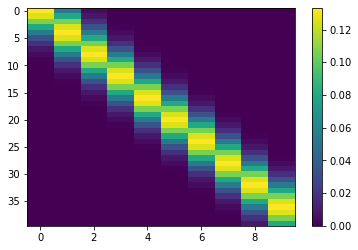

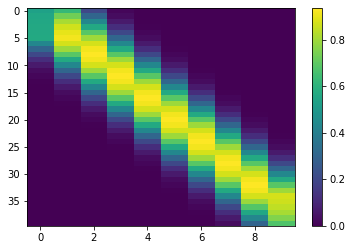

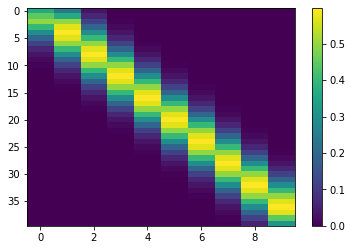

In [11]:
nearby_positions_max = 5
k = np.zeros((2*nearby_positions_max+1, 3))
k[:,1] = 1
precond_posterior = convolve(posterior_array, k, mode='constant', cval=0.0)

print(k.shape)
print(k)

plt.figure()
plt.imshow(posterior_array,aspect='auto')
plt.colorbar()

plt.figure()
plt.imshow(precond_posterior,aspect='auto')
plt.colorbar()


dp = 1
n_nearby_bins = int(nearby_positions_max / 2)
filt = np.ones(2 * n_nearby_bins + 1)
precond_posterior = np.apply_along_axis(
    lambda time_bin: np.convolve(time_bin, filt, mode="same"),
    axis=0, arr=posterior_array
)

plt.figure()
plt.imshow(precond_posterior,aspect='auto')
plt.colorbar()

## generate more realistic events 

by adding some noise and zeroing out columns

D:\ryanh\Anaconda3\envs\replay\lib\site-packages\statsmodels\regression\linear_model.py:764: RuntimeWarning: divide by zero encountered in log


0.07348973335719783
0.6284510255005114


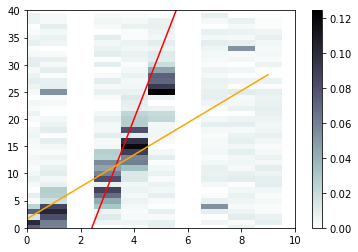

In [11]:
Pr = np.zeros((40,10))
for i in range(10):
    Pr[:,i] = make_gaussian(mu=0+i**2)
# add random noise to all bins    
Pr = Pr * np.random.rand(40,10) + np.random.rand(40,10)*0.01
# add high values to 4 random bins
for i in range(4):
    Pr[np.random.randint(Pr.shape[0]),np.random.randint(Pr.shape[1])] = Pr.mean()*4
# zero out 2 random columns    
for i in range(2):
    Pr[:,np.random.randint(Pr.shape[1])] = 0   

dt = 1
dp = 1

start_position, velocity, radon_position, score, sinogram = detect_line_with_radon(
                                                                    Pr.T,
                                                                    dt,  # s
                                                                    dp,  # cm
                                                                    projection_angles=np.arange(-90, 90, 0.5),  # degrees
                                                                    filter_invalid_positions=False,
                                                                    incorporate_nearby_positions=True,
                                                                    nearby_positions_max=3,  # cm
                                                                    )

rsquared,slope,intercept,log_like = replay_run.score_array(Pr)
# plt.figure()
# plt.pcolormesh(t, p, Pr,cmap=plt.cm.bone_r)
# plt.colorbar()
# plt.plot(time+dt/2,radon_position,color='red')
# plt.title(score)
plt.imshow(Pr,cmap=plt.cm.bone_r,aspect='auto',origin='lower')
plt.colorbar()
plt.plot(radon_position,color='red')
plt.plot(np.arange(Pr.shape[1]),np.arange(Pr.shape[1])*slope+intercept,color='orange')
plt.xlim(0,Pr.shape[1])  
plt.ylim(0,Pr.shape[0]) 
score = _score_line(Pr, radon_position)
print(score)

score = _score_line(Pr, np.arange(Pr.shape[1])*slope+intercept,nearby_positions_max=5)
print(score)

# plt.figure()
# plt.imshow(sinogram,aspect='auto')
# plt.colorbar()

Wall time: 12.4 s


(0.0, 40.0)

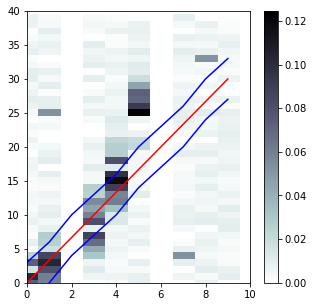

In [12]:
%%time
def sum_between_band(
    Pr,
    slope,
    intercept,
    w=3 # pixels 
):
    line_upper = np.arange(Pr.shape[1])*slope+intercept+w
    line_lower = np.arange(Pr.shape[1])*slope+intercept-w
    line_upper_int = np.around(line_upper).astype(int) # Find nearest position bin
    line_lower_int = np.around(line_lower).astype(int) # Find nearest position bin
    
    # line outside bounds
    if ~np.any(line_upper_int > 0) & ~np.any(line_lower_int > 0):
        return 0
    if ~np.any(line_upper_int < Pr.shape[0]) & ~np.any(line_lower_int < Pr.shape[0]):
        return 0
    values = [Pr[line_lower_int[i]:line_upper_int[i],i] for i in range(Pr.shape[1])]
    
    idx = (line_lower_int >= 0) | (line_upper_int >= 0)
    values = [sum(v) for v in values]
    return np.array(values)[idx].sum()

def fine_line(
    posterior_array,
    slope_max=2500, # max slope to test (cm/sec)
    slope_step=250, # step size (cm/sec)
    intercept_step=12, # max intercept to test (cm)
    dt=.02,
    dp=3
):
    intercepts = np.arange(-Pr.shape[0]*5,Pr.shape[0]*5,intercept_step/dp)
    slopes = np.arange(-slope_max*dt/dp,slope_max*dt/dt,slope_step*dt/dp)
    
    coeffs = np.array(np.meshgrid(intercepts, slopes)).T.reshape(-1,2)

    idx = ((coeffs[:,0] < 0)  & (coeffs[:,1] < 0)) | ((coeffs[:,0] > posterior_array.shape[0]) & (coeffs[:,1] > 0))
    coeffs = coeffs[~idx,:]
    
    scores = []
    for b0,b1 in coeffs:
        scores.append(sum_between_band(posterior_array, b1, b0, w=3))
    idx = np.nanargmax(scores)
    return coeffs[idx,0], coeffs[idx,1], scores[idx] # intercept,slope, score
    
intercept, slope, score = fine_line(Pr)

plt.figure(figsize=(5,5))
plt.imshow(Pr,cmap=plt.cm.bone_r,aspect='auto',origin='lower')
plt.colorbar()
x = np.arange(Pr.shape[1])

plt.plot(x,x*slope+intercept,color='r')

line_upper = np.arange(Pr.shape[1])*slope+intercept+3
line_lower = np.arange(Pr.shape[1])*slope+intercept-3
line_upper_int = np.around(line_upper).astype(int) # Find nearest position bin
line_lower_int = np.around(line_lower).astype(int) # Find nearest position bin
plt.plot(line_upper_int,color='blue')
plt.plot(line_lower_int,color='blue')
plt.xlim(0,Pr.shape[1])  
plt.ylim(0,Pr.shape[0]) 

160

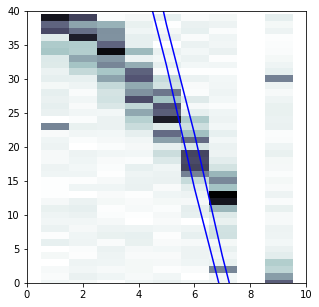

In [217]:
plt.figure(figsize=(5,5))
plt.imshow(Pr,cmap=plt.cm.bone_r,aspect='auto',origin='lower')

slope = -17
intercept=40*3
line_upper = np.arange(Pr.shape[1])*slope+intercept+offset
line_lower = np.arange(Pr.shape[1])*slope+intercept-offset
line_upper_int = np.around(line_upper).astype(int) # Find nearest position bin
line_lower_int = np.around(line_lower).astype(int) # Find nearest position bin
plt.plot(line_upper_int,color='blue')
plt.plot(line_lower_int,color='blue')
plt.xlim(0,Pr.shape[1])  
plt.ylim(0,Pr.shape[0]) 

40*4

In [226]:
%%time
# import itertools
# out = map(''.join, itertools.chain(itertools.product(intercepts, slopes), itertools.product(intercepts, slopes)))
# out

np.array(np.meshgrid(intercepts, slopes)).T.reshape(-1,2)


Wall time: 13 ms


array([[-160.        ,  -13.33333333],
       [-160.        ,  -12.66666667],
       [-160.        ,  -12.        ],
       ...,
       [ 158.        , 1998.        ],
       [ 158.        , 1998.66666667],
       [ 158.        , 1999.33333333]])

In [231]:
%%time
slope_max=2000 # max slope to test (cm/sec)
slope_step=100 # step size (cm/sec)
intercept_step=6 # max intercept to test (cm)
dt=.02
dp=3

intercepts = np.arange(-Pr.shape[0]*4,Pr.shape[0]*4,intercept_step/dp)
slopes = np.arange(-slope_max*dt/dp,slope_max*dt/dt,slope_step*dt/dp)

coeffs = np.array(np.meshgrid(intercepts, slopes)).T.reshape(-1,2)

idx = ((coeffs[:,0] < 0)  & (coeffs[:,1] < 0)) | ((coeffs[:,0] > posterior_array.shape[0]) & (coeffs[:,1] > 0))
coeffs = coeffs[~idx,:]


coeffs.shape

Wall time: 19.9 ms


(304579, 2)

[array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([0.00352246, 0.00756242, 0.00082861, 0.00806492, 0.0010213 ,
       0.00976916, 0.0074556 , 0.00843793])]


0.0

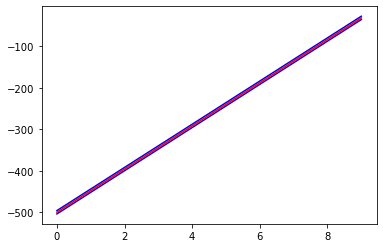

In [85]:
slope,intercept = 52, -500
band_width = 7
offset = band_width/2
line_upper = np.arange(Pr.shape[1])*slope+intercept+offset
line_lower = np.arange(Pr.shape[1])*slope+intercept-offset
line_upper_int = np.around(line_upper).astype(int) # Find nearest position bin
line_lower_int = np.around(line_lower).astype(int) # Find nearest position bin
    
plt.plot(line_upper_int,color='blue')
plt.plot(line_lower_int,color='blue')
plt.plot(x,x*slope+intercept,color='r')

idx = (line_lower_int >= 0) | (line_upper_int >= 0)
# line_lower_int = line_lower_int[idx]
# line_lower_int = line_upper_int[idx]

values = [Pr[line_lower_int[i]:line_upper_int[i],i] for i in range(Pr.shape[1])]
# values = values[0]

# values[np.where(idx)]
# np.vstack(values)
print(values)
values = [sum(v) for v in values]
np.array(values)[idx].sum()
# np.vstack(values)[idx].sum()

In [42]:
Pr[line_lower_int[0],0]

0.04664957976752553

In [18]:
def sum_between_band(
    Pr,
    slope,
    intercept,
    band_width=7 # pixels 
):
    line_upper = np.arange(Pr.shape[1])*slope+intercept+offset
    line_lower = np.arange(Pr.shape[1])*slope+intercept-offset
    line_upper_int = np.around(line_upper).astype(int) # Find nearest position bin
    line_lower_int = np.around(line_lower).astype(int) # Find nearest position bin
    
    values = [Pr[line_lower_int[i]:line_upper_int[i],i] for i in range(Pr.shape[1])]
    return np.hstack(values).sum()

sum_between_band(Pr,slope,intercept)

3.2979986727900874

In [435]:
values = [Pr[line_lower_int[i]:line_upper_int[i],i] for i in range(Pr.shape[1])]
np.hstack(values).sum()



3.181766725443776

In [432]:
7*3

21

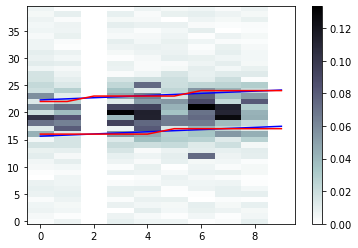

In [15]:
band = 20 #cm
offset = band/3 / 2

line = np.arange(Pr.shape[1])*slope+intercept
line_upper = np.arange(Pr.shape[1])*slope+intercept+offset
line_lower = np.arange(Pr.shape[1])*slope+intercept-offset

line_upper_int = np.around(line_upper).astype(int) # Find nearest position bin
line_lower_int = np.around(line_lower).astype(int) # Find nearest position bin

plt.imshow(Pr,cmap=plt.cm.bone_r,aspect='auto',origin='lower')
plt.colorbar()
# plt.plot(line,color='red')
plt.plot(line_upper,color='blue')
plt.plot(line_lower,color='blue')

plt.plot(line_upper_int,color='red')
plt.plot(line_lower_int,color='red')

Wall time: 82.8 ms


D:\ryanh\github\cell_assembly_replay\cell_assembly_replay\replay_run.py:159: RuntimeWarning: divide by zero encountered in true_divide
D:\ryanh\github\cell_assembly_replay\cell_assembly_replay\replay_run.py:159: RuntimeWarning: invalid value encountered in true_divide
D:\ryanh\github\cell_assembly_replay\cell_assembly_replay\replay_run.py:159: RuntimeWarning: invalid value encountered in subtract
D:\ryanh\github\cell_assembly_replay\cell_assembly_replay\replay_run.py:200: RuntimeWarning: invalid value encountered in add


Text(0.5, 1.0, '0.1572890943921128')

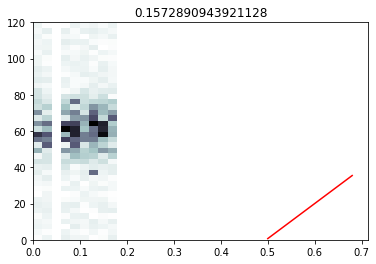

In [16]:
%%time
start_position, velocity, radon_position, score = replay_run.detect_line_with_radon(
                                                                Pr.T,
                                                                dt,  # s
                                                                dp,  # cm
                                                                projection_angles=np.arange(-90, 90, 0.5),  # degrees
                                                                filter_invalid_positions=True,
                                                                incorporate_nearby_positions=True,
                                                                nearby_positions_max=15,  # cm
                                                            )
plt.pcolormesh(t, p, Pr,cmap=plt.cm.bone_r)
plt.plot(time+dt/2,radon_position,color='red')
plt.title(score)

In [15]:
y = radon_position

dy = np.abs(np.diff(y))
# get cumulative distance 
traj_dist = (np.nansum(dy))
# calculate avg speed of trajectory (dist(cm) / time(sec))
traj_speed = (np.nansum(dy) / (np.nanmax(time) - np.nanmin(time)))
# get mean step size 
traj_step = (np.nanmean(dy))

print(traj_dist, traj_speed, traj_step)

104.4012535622659 580.0069642348105 11.60013928469621


In [ ]:
from sklearn.isotonic import IsotonicRegression

def map_estimate(posterior, place_bin_centers):
    """ From Eric Denovellis """
    posterior[np.isnan(posterior)] = 0.0
    return place_bin_centers[posterior.argmax(axis=1)].squeeze()
def isotonic_regression(posterior, time, place_bin_centers):
    """ From Eric Denovellis """
    place_bin_centers = place_bin_centers.squeeze()
    posterior[np.isnan(posterior)] = 0.0

    map_ = map_estimate(posterior, place_bin_centers)
    map_probabilities = np.max(posterior, axis=1)

    regression = IsotonicRegression(increasing='auto').fit(
        X=time,
        y=map_,
        sample_weight=map_probabilities,
    )
    
    score = regression.score(
        X=time,
        y=map_,
        sample_weight=map_probabilities,
    )

    prediction = regression.predict(time)

    return prediction,score

y, iso_score = isotonic_regression(Pr.T, time, place_bin_centers)
print(iso_score)
plt.pcolormesh(t, p, Pr,cmap=plt.cm.bone_r)
plt.plot(time+dt/2,y,color='red')

In [ ]:
dy = np.abs(np.diff(y))
# get cumulative distance 
traj_dist = (np.nansum(dy))
# calculate avg speed of trajectory (dist(cm) / time(sec))
traj_speed = (np.nansum(dy) / (np.nanmax(time) - np.nanmin(time)))
# get mean step size 
traj_step = (np.nanmean(dy))

print(traj_dist, traj_speed, traj_step)

In [18]:
from itertools import groupby

def find_max_consecutive(Pr,place_bin_centers,min_dis=25):
    map_ = map_estimate(Pr, place_bin_centers)
    L = np.diff(map_)<min_dis
    grouped_L = [(k, sum(1 for i in g)) for k,g in groupby(L)]
    n_contig = []
    for item in grouped_L:
        if item[0] == 1:
            n_contig.append(item[1]) 
    return max(n_contig)

obs_n_cons = find_max_consecutive(Pr.T,place_bin_centers)
obs_n_cons

9

In [ ]:
%%time

def shuff_randon(Pr,time,place_bin_centers,dt=0.02,dp=3):
    posterior_cs = replay.column_cycle_array(Pr)
    posterior_ts = replay.time_swap_array(Pr)
            
    r2_col_cycle,slope,intercept,log_like = replay_run.score_array(posterior_cs)
    _, _, _, radon_col_cycle = replay_run.detect_line_with_radon(posterior_cs.T,dt,dp,incorporate_nearby_positions=False)
    corr_col_cycle = replay_run.weighted_correlation(posterior_cs.T, time, place_bin_centers)
    _,iso_col_cycle = isotonic_regression(posterior_cs.T, time, place_bin_centers)
    n_con_col_cycle = find_max_consecutive(posterior_cs.T,place_bin_centers)

    r2_ts,slope,intercept,log_like = replay_run.score_array(posterior_ts)
    _, _, _, radon_ts = replay_run.detect_line_with_radon(posterior_ts.T,dt,dp,incorporate_nearby_positions=False)
    corr_ts = replay_run.weighted_correlation(posterior_ts.T, time, place_bin_centers)
    _,iso_ts = isotonic_regression(posterior_cs.T, time, place_bin_centers)
    n_con_ts = find_max_consecutive(posterior_cs.T,place_bin_centers)

    return radon_col_cycle,r2_col_cycle,corr_col_cycle,iso_col_cycle,n_con_col_cycle,radon_ts,r2_ts,corr_ts,iso_ts,n_con_ts

num_cores = multiprocessing.cpu_count()         
(
    radon_col_cycle,r2_col_cycle,corr_col_cycle,iso_col_cycle,n_con_col_cycle,radon_ts,r2_ts,corr_ts,iso_ts,n_con_ts
) = zip(*Parallel(n_jobs=num_cores)(delayed(shuff_randon)(Pr,time,place_bin_centers) for i in range(1000)))

In [20]:
_,radon_pval_col_cycle = replay_run.get_significant_events(score, np.expand_dims(radon_col_cycle, axis=1))
_,r2_pval_col_cycle = replay_run.get_significant_events(r2, np.expand_dims(r2_col_cycle, axis=1))
_,corr_pval_col_cycle = replay_run.get_significant_events(corr, np.expand_dims(corr_col_cycle, axis=1))
_,iso_pval_col_cycle = replay_run.get_significant_events(iso_score, np.expand_dims(iso_col_cycle, axis=1))
_,n_cons_pval_col_cycle = replay_run.get_significant_events(obs_n_cons, np.expand_dims(n_con_col_cycle, axis=1))

plt.figure()
plt.hist(radon_col_cycle,200)
plt.axvline(score,color='r')
plt.title('radon'+str(radon_pval_col_cycle))

plt.figure()
plt.hist(r2_col_cycle,200)
plt.axvline(r2,color='r')
plt.title('r2'+str(r2_pval_col_cycle))

plt.figure()
plt.hist(corr_col_cycle,200)
plt.axvline(corr,color='r')
plt.title('correlation'+str(corr_pval_col_cycle))

plt.figure()
plt.hist(iso_col_cycle,200)
plt.axvline(iso_score,color='r')
plt.title('iso'+str(iso_pval_col_cycle))

plt.figure()
plt.hist(n_con_col_cycle,200)
plt.axvline(obs_n_cons,color='r')
plt.title('n consecutive'+str(n_cons_pval_col_cycle))

NameError: name 'radon_col_cycle' is not defined

In [ ]:
_,radon_pval_col_cycle = replay_run.get_significant_events(score, np.expand_dims(radon_ts, axis=1))
_,r2_pval_col_cycle = replay_run.get_significant_events(r2, np.expand_dims(r2_ts, axis=1))
_,corr_pval_col_cycle = replay_run.get_significant_events(corr, np.expand_dims(corr_ts, axis=1))
_,iso_pval_col_cycle = replay_run.get_significant_events(iso_score, np.expand_dims(iso_ts, axis=1))
_,n_cons_pval_col_cycle = replay_run.get_significant_events(obs_n_cons, np.expand_dims(n_con_ts, axis=1))

plt.figure()
plt.hist(radon_ts,200)
plt.axvline(score,color='r')
plt.title('radon'+str(radon_pval_col_cycle))

plt.figure()
plt.hist(r2_ts,200)
plt.axvline(r2,color='r')
plt.title('r2'+str(r2_pval_col_cycle))

plt.figure()
plt.hist(corr_ts,200)
plt.axvline(corr,color='r')
plt.title('correlation'+str(corr_pval_col_cycle))

plt.figure()
plt.hist(iso_ts,200)
plt.axvline(iso_score,color='r')
plt.title('iso'+str(iso_pval_col_cycle))

plt.figure()
plt.hist(n_con_ts,200)
plt.axvline(obs_n_cons,color='r')
plt.title('n consecutive'+str(n_cons_pval_col_cycle))

# test 2 parallel loops

In [ ]:
%%time
def get_Pr(mu=40,square_fac=1):
    Pr = np.zeros((40,10))
    for i in range(10):
        Pr[:,i] = make_gaussian(mu=mu-i**square_fac)

    start_position, velocity, radon_position, score = replay_run.detect_line_with_radon(
        Pr.T,
        dt,  # s
        dp,  # cm
        projection_angles=np.arange(-90, 90, 0.5),  # degrees
        filter_invalid_positions=True,
        incorporate_nearby_positions=False,
        nearby_positions_max=15,  # cm
    )
    r2,slope,intercept,log_like = replay_run.score_array(Pr)
    corr = replay_run.weighted_correlation(Pr.T, time, place_bin_centers)
    return Pr,corr

def run_all(square_fac):
    Pr, corr = get_Pr(mu=40,square_fac=square_fac)
    radon_col_cycle,r2_col_cycle,corr_col_cycle = zip(*Parallel(n_jobs=num_cores)(delayed(shuff_randon)(Pr,time,place_bin_centers) for i in range(1000)))
    _,corr_pval_col_cycle = replay_run.get_significant_events(corr, np.expand_dims(corr_col_cycle, axis=1))
    return corr_pval_col_cycle,corr

num_cores = multiprocessing.cpu_count()         

corr_pval_col_cycle_para,corr_para = zip(*Parallel(n_jobs=num_cores)(delayed(run_all)(square_fac=square_fac) for square_fac in np.arange(1,2,.1)))
# pval = []
# for square_fac in np.arange(1,2,.1):
#     Pr, corr = get_Pr(mu=40,square_fac=1)
#     radon_col_cycle,r2_col_cycle,corr_col_cycle = zip(*Parallel(n_jobs=num_cores)(delayed(shuff_randon)(Pr,time,place_bin_centers) for i in range(1000)))
#     _,corr_pval_col_cycle = replay_run.get_significant_events(corr, np.expand_dims(corr_col_cycle, axis=1))
#     pval.append(corr_pval_col_cycle)

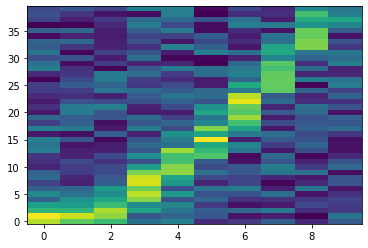

In [209]:
Pr = np.zeros((40,10))
mu = 10
for i in range(10):
    Pr[:,i] = make_gaussian(mu=i**1.7) # sigma=np.random.rand()*1
Pr = Pr + np.random.rand(40,10)*0.1   
plt.imshow(Pr,aspect='auto',origin='lower')    

In [10]:
%%time

def get_Pr(mu=40,square_fac=1):
    Pr = np.zeros((40,10))
    for i in range(10):
        Pr[:,i] = make_gaussian(mu=mu-i**square_fac)
    Pr = Pr + np.random.rand(40,10)*0.1   

    start_position, velocity, radon_position, score = replay_run.detect_line_with_radon(
        Pr.T,
        dt,  # s
        dp,  # cm
        projection_angles=np.arange(-90, 90, 0.5),  # degrees
        filter_invalid_positions=True,
        incorporate_nearby_positions=False,
        nearby_positions_max=15,  # cm
    )
    corr = replay_run.weighted_correlation(Pr.T, time, place_bin_centers)
    return Pr,corr,score

def shuff_pr(Pr,time,place_bin_centers,dt=0.02,dp=3):
    
    posterior_cs = replay.column_cycle_array(Pr)
    corr = replay_run.weighted_correlation(posterior_cs.T, time, place_bin_centers)
    
    start_position, velocity, radon_position, score = replay_run.detect_line_with_radon(
        posterior_cs.T,
        dt,  # s
        dp,  # cm
        projection_angles=np.arange(-90, 90, 0.5),  # degrees
        filter_invalid_positions=True,
        incorporate_nearby_positions=False,
        nearby_positions_max=15,  # cm
    )
    return score,corr

num_cores = multiprocessing.cpu_count()         

pval = []
save_corr = []
for i,square_fac in enumerate(np.arange(1,2,.1)):
    print(i)
    Pr, corr, radon_score = get_Pr(mu=40,square_fac=square_fac)
    radon_score_col_cycle,corr_col_cycle = zip(*Parallel(n_jobs=num_cores)(delayed(shuff_pr)(Pr,time,place_bin_centers) for _ in range(1000)))
    _,radon_pval_col_cycle = replay_run.get_significant_events(radon_score, np.expand_dims(radon_score_col_cycle, axis=1))
    _,corr_pval_col_cycle = replay_run.get_significant_events(corr, np.expand_dims(corr_col_cycle, axis=1))

    pval.append(corr_pval_col_cycle)
    save_corr.append(corr)

0
1
2
3
4
5
6
7
8
9
Wall time: 2min 4s


In [14]:
%%time

n_shuffles = 1000
pval = []
save_corr = []
for i,square_fac in enumerate(np.arange(1,2,.1)):
    print(i)
    Pr, corr, radon_score = get_Pr(mu=40,square_fac=square_fac)
    
    radon_score_col_cycle = np.zeros((n_shuffles,1))
    corr_col_cycle = np.zeros((n_shuffles,1))

    for idx in range(n_shuffles):
        radon_score_col_cycle[idx],corr_col_cycle[idx] = shuff_pr(Pr,time,place_bin_centers)

#     radon_score_col_cycle,corr_col_cycle = zip(*Parallel(n_jobs=num_cores)(delayed(shuff_pr)(Pr,time,place_bin_centers) for _ in range(1000)))
    _,radon_pval_col_cycle = replay_run.get_significant_events(radon_score, radon_score_col_cycle)
    _,corr_pval_col_cycle = replay_run.get_significant_events(corr, corr_col_cycle)

    pval.append(corr_pval_col_cycle)
    save_corr.append(corr)

0
1
2
3
4
5
6
7
8
9
Wall time: 8min 3s


In [19]:
%%time
corr = replay_run.weighted_correlation(Pr.T, time, place_bin_centers)
corr

Wall time: 0 ns


0.35244607772628084

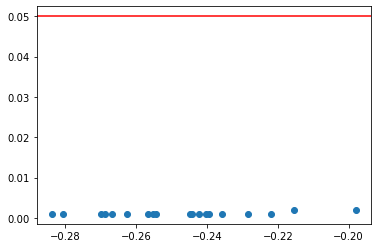

In [215]:
plt.scatter(save_corr,pval)
plt.axhline(0.05,color='r')

# messing with cv2 below

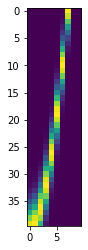

In [87]:
img_n = cv2.normalize(src=Pr, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
plt.imshow(img_n)

In [88]:
# Pr.dtype
# edges.dtype
# img = Pr.astype(np.uint8)
# img
# data = Pr
# info = np.iinfo(data.dtype) # Get the information of the incoming image type
# data = data.astype(np.float64) / info.max # normalize the data to 0 - 1
# data = 255 * data # Now scale by 255
# img = data.astype(np.uint8)
cv2.imshow("Window", img_n)

In [103]:
# import cv2
# import numpy as np

# img = cv2.imread(r'C:\Users\ryanh\Downloads\houghlines3.jpg')
edges = cv2.normalize(src=Pr, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

# gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
# edges = cv2.Canny(gray,50,150,apertureSize = 3)

# lines = cv2.HoughLines(self.edges, hough_rho_res, hough_theta_res, hough_votes_thresh)

lines = cv2.HoughLines(edges,1,np.pi/180,10)
for rho,theta in lines[0]:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 100*(-b))
    y1 = int(y0 + 100*(a))
    x2 = int(x0 - 100*(-b))
    y2 = int(y0 - 100*(a))

    cv2.line(img,(x1,y1),(x2,y2),(255,0,0),2)

cv2.imwrite(r'C:\Users\ryanh\Downloads\houghlines0.jpg',img)

True

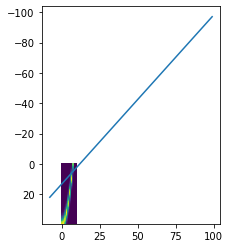

In [105]:
plt.imshow(img_n)
plt.plot((x1,y1),(x2,y2))

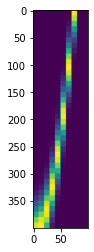

In [116]:
scale_percent = 1000 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
resized = cv2.resize(edges, dim, interpolation = cv2.INTER_AREA)
plt.imshow(resized)

In [125]:
# img = cv2.imread('dave.jpg')
# gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
# edges = cv2.Canny(gray,50,150,apertureSize = 3)
edges = cv2.normalize(src=Pr, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

scale_percent = 1000 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
resized = cv2.resize(edges, dim, interpolation = cv2.INTER_AREA)

minLineLength = 4
maxLineGap = 0
lines = cv2.HoughLinesP(resized,1,np.pi/180,10,minLineLength,maxLineGap)
# for x1,y1,x2,y2 in lines[0]:
#     cv2.line(resized,(x1,y1),(x2,y2),(0,255,0),2)

# cv2.imwrite(r'C:\Users\ryanh\Downloads\houghlines5.jpg',resized)

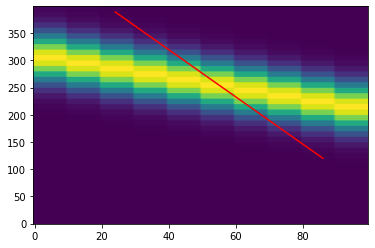

In [175]:
Pr, corr = get_Pr(mu=30,square_fac=1)

img = cv2.normalize(src=Pr, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

minLineLength = 10
maxLineGap = 10
lines = cv2.HoughLinesP(img,1,np.pi/180,100,minLineLength,maxLineGap)

x1 = lines[0][0][0]
y1 = lines[0][0][1]
x2 = lines[0][0][2]
y2 = lines[0][0][3]

x = [x1,x2]
y = [y1,y2]

plt.imshow(img,aspect='auto',origin='lower')
plt.plot(x,y,color='r')

In [163]:
lines

array([[[ 0, 39,  3, 22]],

       [[ 4, 36,  7,  0]],

       [[ 5, 18,  6,  0]],

       [[ 3, 39,  3, 26]],

       [[ 0, 30,  1, 39]],

       [[ 4, 16,  5, 29]]], dtype=int32)